In [1]:
# notebook to check on individual ignition delay detections

In [1]:
import cantera as ct
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the model
cti_path = '/work/westgroup/harris.se/autoscience/autoscience/butane/improved_models/chem_2022-09-08.cti'
gas = ct.Solution(cti_path)

In [3]:
# load experimental data
ignition_delay_data = '../butane/butane_ignition_delay.csv'
df = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df[df['Table'] == 7]

In [4]:
# Load the experimental conditions
ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 7]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm


# list of starting conditions
# Mixture compositions taken from table 2 of
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
concentrations = []
# for phi = 1
x_diluent = 0.7649
conc_dict = {
    'O2(2)': 0.2038,
    'butane(1)': 0.03135
}

for i in range(0, len(table7)):
    x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
    x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
    x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    concentrations.append(conc_dict)

In [5]:
# create empty arrays for the models
rmg_tau7 = np.zeros(len(tau7))

In [6]:
def run_simulation(gas, T, P, X):
    # function to run a RCM simulation

    t_end = 1.0  # time in seconds
    gas.TPX = T, P, X
    
    
    env = ct.Reservoir(ct.Solution('air.xml'))
    reactor = ct.IdealGasReactor(gas)
    wall = ct.Wall(reactor, env, A=1.0, velocity=0)
    reactor_net = ct.ReactorNet([reactor])
    
    
    times = [0]
    T = [reactor.T]
    P = [reactor.thermo.P]
    X = [reactor.thermo.X]  # mol fractions
    while reactor_net.time < t_end:
        reactor_net.step()

        times.append(reactor_net.time)
        T.append(reactor.T)
        P.append(reactor.thermo.P)
        X.append(reactor.thermo.X)
    
    return (times, T, P, X)

In [7]:
def get_ignition_delay(times, T, P, X, plot=False, title='', save=''):
    # look for time with largest derivative
    slopes = np.gradient(P, times)
    i = np.argmax(slopes)
    
    
    if plot:
        # plot to check if the answer makes sense
        plt.clf()
        plt.plot(times, P)
        plt.axvline(x=times[i], color='green')
        max_time = min(times[i] * 1.1, times[-1])
        plt.xlim([0, max_time])
        plt.xlabel('Time (s)')
        plt.ylabel('Pressure (Pa)')
        
        if title:
            plt.title(title)
        else:
            plt.title('Ignition Delay')
        
        if save:
            plt.savefig(save)

    
    return i, times[i]
    # look for time when it reaches half of maximum pressure


# Run the Simulations

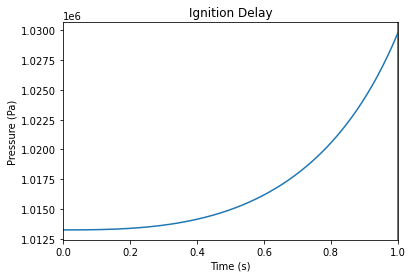

In [9]:
# for i in range(0, len(table7)):
for i in [7]:
    # aramco, keep as is
    X = concentrations[i]
    t, T, P, X = run_simulation(gas, T7[i], P7[i], X)
    save_name = f'rmg_7-{i:04}.png'
    index, delay_time = get_ignition_delay(t, T, P, X, plot=True, save=save_name)
    rmg_tau7[i] = delay_time

Text(0, 0.5, 'Pressure (Pa)')

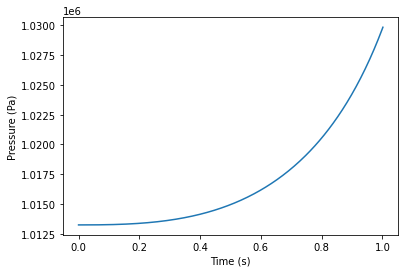

In [24]:
plt.clf()
N = 1000
plt.plot(t[:N], P[:N])
# plt.axvline(x=t[i], color='green')
# max_time = min(t[i] * 1.1, t[-1])
# plt.xlim([0, max_time])
plt.xlabel('Time (s)')
plt.ylabel('Pressure (Pa)')